In [1]:
import sys
sys.version

import exoplanet
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate import *
from model import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)



WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


exoplanet.__version__ = '0.5.1'


/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:352: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:427: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:452: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


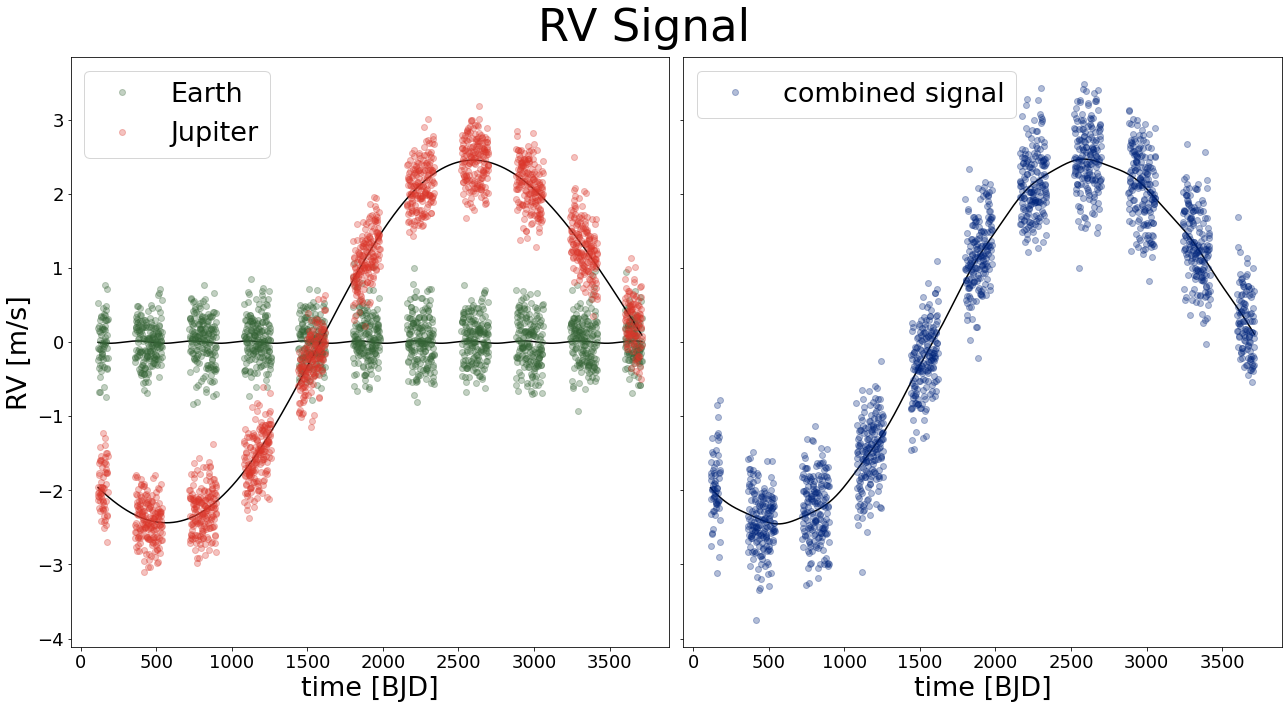

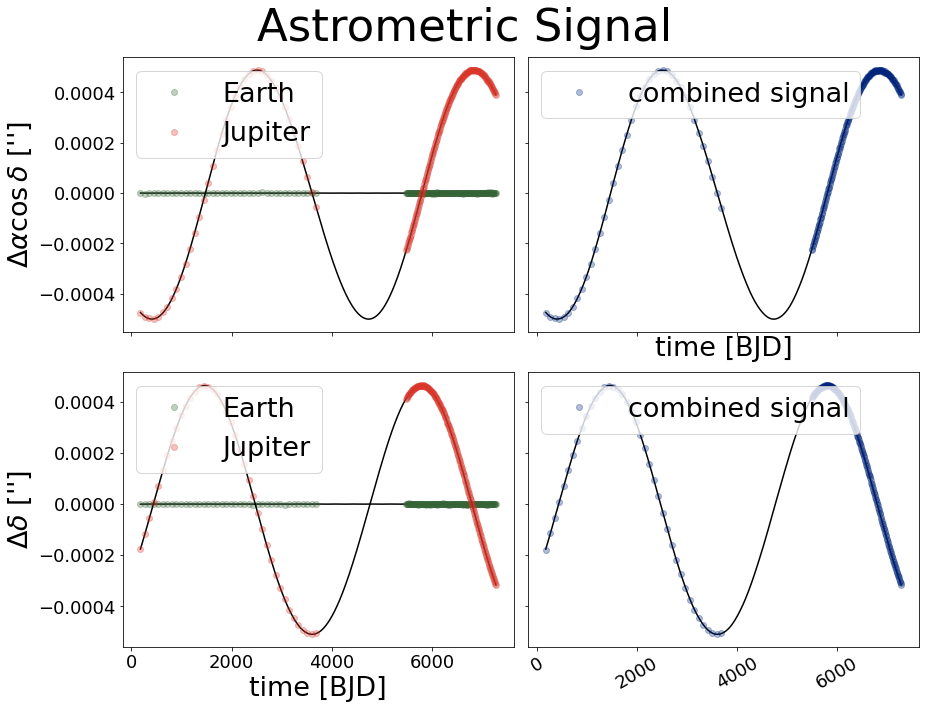

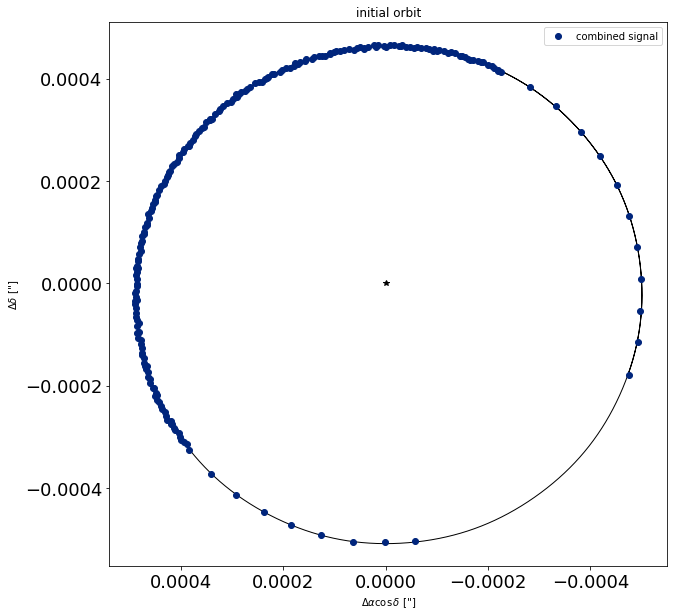

In [2]:
T_subtract = 2454000
# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333 - T_subtract
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(10.0)
m_earth = 1*3.00273e-6 #units m_sun



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278 - T_subtract
omega_jup = np.radians(274.3) - 2*np.pi
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.31) + inclination_earth
m_jup = 317.83*3.00273e-6 #units m_sun


m_sun = 333030 #earth masses


times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+3600):
    if ii % 90 == 0:
        times_observed_astrometry.append(ii)

t_1 =  times_observed_astrometry[-1]+1800
for ii in range(t_1, t_1+1800):
    if ii % 10 == 0:
        times_observed_astrometry.append(ii)      
        
times_observed_rv = []
t_0 = int(Tper_earth)
add_data = True
for ii in range(t_0, t_0+3600):
    
    if ii % 180 == 0:
        if add_data:
            add_data = False
        else:
            add_data = True
       
    if add_data:
        times_observed_rv.append(ii)
        

orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]

n_planets = 2
orbit_params = [orbit_params_earth, orbit_params_jup]


sigma_rv = 0.3

sigma_ra = 1e-6
sigma_dec = 1e-6
parallax = 0.1



times, rv_results, theta_results, rho_results = simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_ra,
    sigma_dec,
    parallax,
    orbit_params,
    ['#366537', '#db372b', '#00257c'],
    ['Earth', 'Jupiter'],
    times_observed_rv = times_observed_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
[rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
[ra_orbit, ra_orbit_sum, ra_sim, ra_sim_sum],
[dec_orbit, dec_orbit_sum, dec_sim, dec_sim_sum]]  = times, rv_results, theta_results, rho_results



In [3]:
x_rv = np.array(times_observed_rv)
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), sigma_rv)

x_astrometry = np.array(times_observed_astrometry)
ra_data = ra_sim_sum
ra_err = np.full(np.shape(ra_data), sigma_ra)
dec_data = dec_sim_sum
dec_err = np.full(np.shape(dec_data), sigma_dec)


# make a fine grid that spans the observation window for plotting purposes
t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

# for predicted orbits
t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)





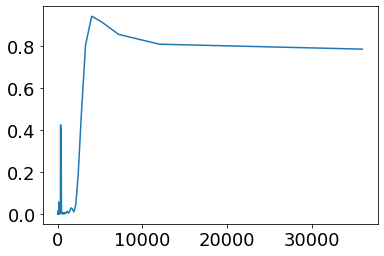

3998.8888888888896
330.18348623853217


In [4]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(x_rv, y_rv).autopower()
period = 1/frequency


period_cut1 = period[period > 10]
power_cut1 = power[period > 10]

plt.plot(period_cut1, power_cut1) 
#plt.xlim(1000,10000)
plt.show()


indices = power_cut1.argsort()[-1:][::-1]
period1 = np.array(period_cut1[indices][0])
print(period1)

period1_min_cut = 2000
#period_cut1 > period1_min_cut so we don't double count

period_cut2 = period_cut1[period_cut1 < period1_min_cut]

power_cut2 = power_cut1[period_cut1 < period1_min_cut]


indices = power_cut2.argsort()[-1:][::-1]
period2 = period_cut2[indices][0]
print(period2)



finding RV model solutions


optimizing logp for variables: [tperi]


message: Desired error not necessarily achieved due to precision loss.
logp: -45231.651158346416 -> -655.461843185474
optimizing logp for variables: [logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -655.461843185474 -> -604.2424587082439
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -604.2424587082439 -> -581.6813358823233
optimizing logp for variables: [logs, ecs, logK, tperi, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -581.6813358823233 -> -553.4428933228617


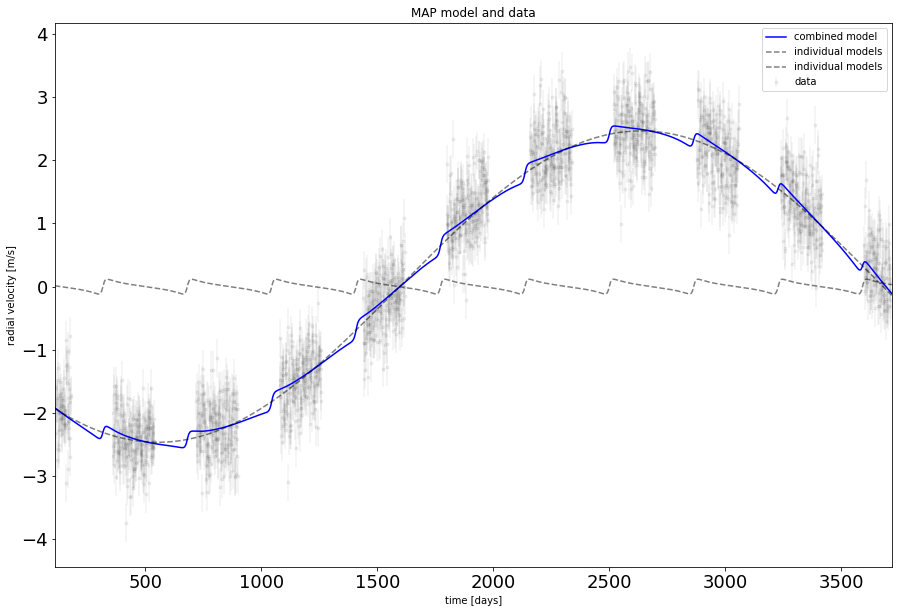

In [5]:

periods_guess = [period2, period1]
#periods_guess = [P_earth, P_jup]

Ks_guess = xo.estimate_semi_amplitude(periods_guess, x_rv, y_rv, y_rv_err)


print("finding RV model solutions")
rv_map_soln = model_rv(periods_guess, Ks_guess, x_rv, y_rv, y_rv_err)

fig, ax = plt.subplots(1, figsize = [15,10])

ax.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax.plot(t_rv, rv_map_soln["rv_model_pred"], "b", label="combined model", zorder=2)
ax.plot(t_rv, rv_map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")


ax.legend(fontsize=10)
ax.set_xlim(t_rv.min(), t_rv.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")
ax.set_title("MAP model and data")

plt.show()



In [6]:
print("finding joint model solutions")
parallax = 0.1 # arcsec
model, map_soln = model_both(rv_map_soln, x_rv, y_rv, y_rv_err, x_astrometry, 
                             ra_data, ra_err, dec_data, dec_err, parallax)



finding joint model solutions
RV Solutions
------------
P:  [ 363.91731816 4169.10372851]
K:  [0.11720628 2.46787792]
T_peri:  [1045.00206818 1914.05165434]
eccentricity:  [6.85073724e-01 2.36535244e-07]
omega:  [-1.57887256 -1.09237003]


optimizing logp for variables: [Omega_plus, Omega_minus, sqrtm_sini_1, sqrtm_cosi_1]


message: NaN result encountered.
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [phase, logP]


message: NaN result encountered.
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [log_rv, log_ra_s, log_dec_s, sqrtm_cosi_1, sqrtm_sini_1, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


message: NaN result encountered.
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [Omega_plus, Omega_minus, sqrtm_sini_1, sqrtm_cosi_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -12713362.63605719 -> -89342.22539646568
optimizing logp for variables: [phase, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -89342.22539646568 -> -25632.621532276196
optimizing logp for variables: [log_rv, log_ra_s, log_dec_s, sqrtm_cosi_1, sqrtm_sini_1, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


array: [-1.14640608e+00 -1.38155106e+01 -1.38155106e+01  8.56951054e+00
 -3.07019434e+00 -6.58011142e+00 -4.16370399e+00  1.79375554e+00
  2.28844724e+00  7.77905399e+00 -1.49374872e+01  4.63784200e+00
  1.88051009e+01  4.37865338e-01 -3.44922245e-01 -8.07807382e-01
  8.40149742e-04 -4.12902158e+01 -1.83867081e-03  4.59033324e-01
  2.29423703e+00  1.62828883e+00]
point: {'m_plx_interval__': array(1.62828883), 'logP_interval__': array([0.45903332, 2.29423703]), 'ecs_unitdisk+interval__': array([[-8.07807382e-01,  8.40149742e-04],
       [-4.12902158e+01, -1.83867081e-03]]), 'Omega_plus_angle__': array([[ 0.43786534],
       [-0.34492225]]), 'Omega_minus_angle__': array([[ 4.637842  ],
       [18.80510088]]), 'phase_angle__': array([[  1.79375554,   2.28844724],
       [  7.77905399, -14.93748722]]), 'sqrtm_sini_1_interval__': array([-6.58011142, -4.16370399]), 'sqrtm_cosi_1_interval__': array([ 8.56951054, -3.07019434]), 'log_dec_s': array(-13.81551058), 'log_ra_s': array(-13.81551059),

Traceback (most recent call last):
  File "/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/theano/compile/function/types.py", line 974, in __call__
    self.fn()
  File "/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/theano/graph/op.py", line 476, in rval
    r = p(n, [x[0] for x in i], o)
  File "/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/exoplanet_core/pymc/ops.py", line 76, in perform
    driver.solve_kepler(M, ecc, sinf, cosf)
ValueError: eccentricity must be in the range [0, 1)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/pymc3_ext/optim.py", line 213, in __call__
    res = self.func(
  File "/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/theano/compile/function/types.py", line 987, in __call__
    raise_with_op(
  File "/Users/Danielyahalomi/anaconda3

ValueError: eccentricity must be in the range [0, 1)
Apply node that caused the error: Kepler(Elemwise{Composite{(i0 * ((i1 / i2) - i3))}}.0, Alloc.0)
Toposort index: 151
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(220, 2), (220, 2)]
Inputs strides: [(16, 8), (16, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{Composite{((i0 * i1 * i2 * i3 * i4 * i5 * i6 * i7) / i8)}}(TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{((-(((Switch(i0, (i1 * i2 * i3 * i4 * i5 * i6), i7) + Switch(i8, (i9 * i10 * i11 * i4 * i5 * i12), i7)) / i13) + ((-(Switch(i0, (i1 * i2 * i13 * i11 * i14 * i5), i7) + Switch(i8, (i9 * i10 * i13 * i3 * i14 * i5 * i12), i7))) / i15))) + ((Switch(i0, (i1 * i2 * i3 * i14 * i16 * i6), i7) + Switch(i8, (i9 * i10 * i11 * i14 * i16 * i12), i7)) / i13) + ((Switch(i0, (i1 * i2 * i13 * i11 * i4 * i16), i7) + Switch(i8, (i9 * i10 * i13 * i3 * i4 * i16 * i12), i7)) / i15))}}[(0, 3)].0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.0, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0), Elemwise{Composite{((i0 * i1 * i2 * i3 * i4 * i5 * i6) / i7)}}(TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{(((Switch(i0, (i1 * i2 * i3 * i4 * i5 * i6), i7) + Switch(i8, (i9 * i10 * i11 * i4 * i5 * i12), i7)) / i13) + ((-(Switch(i0, (i1 * i2 * i13 * i11 * i14 * i5), i7) + Switch(i8, (i9 * i10 * i13 * i3 * i14 * i5 * i12), i7))) / i15) + ((Switch(i0, (i1 * i2 * i3 * i14 * i16 * i6), i7) + Switch(i8, (i9 * i10 * i11 * i14 * i16 * i12), i7)) / i13) + ((Switch(i0, (i1 * i2 * i13 * i11 * i4 * i16), i7) + Switch(i8, (i9 * i10 * i13 * i3 * i4 * i16 * i12), i7)) / i15))}}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.0, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0), Elemwise{Composite{(((i0 * i1 * i2 * i3 * i4 * i5 * i6) / i7) + ((i0 * i8 * i2 * i3 * i4 * i5 * i9) / i7))}}(TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0, InplaceDimShuffle{x,0}.0, Kepler.0), Elemwise{Composite{(((i0 * i1 * i2 * i3 * i4 * i5 * i6) / i7) - ((i0 * i8 * i2 * i3 * i4 * i5 * i9) / i7))}}(TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0, InplaceDimShuffle{x,0}.0, Kepler.0), Elemwise{Composite{((i0 * i1) + (i2 * i3))}}(Elemwise{Composite{((i0 * i1) + (i2 * i3 * i4))}}.0, Kepler.1, Elemwise{Composite{((i0 * i1 * i2) + (i3 * i4 * i5))}}[(0, 1)].0, Kepler.0), Elemwise{Composite{(((i0 * i1 * i2 * i3 * i4 * i5 * i6 * i7 * i8) / i9) + ((i10 * i11 * i3 * i4 * i5 * i2 * i7 * i8) / i12))}}[(0, 7)](TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{((i0 * i1) + (i2 * i3))}}.0, InplaceDimShuffle{x,x}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, Kepler.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul,no_inplace}.0, TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{((i0 * i1) + (i2 * i3 * i4))}}.0, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0), Elemwise{Composite{(Switch(i0, (i1 * i2 * i3 * i4 * (((i5 * i6 * i7 * i8 * i9 * i10 * i11) / (i12 * i13)) - ((i14 * i15 * i16 * i17 * i18 * i19 * i20) / (i12 * i13)))), i21) + Switch(i22, (i23 * i24 * i25 * i4 * (((i26 * i27 * i28 * i29 * i30 * i31 * i11) / (i12 * i13)) - ((i32 * i33 * i34 * i35 * i36 * i37 * i20) / (i12 * i13)))), i21) + Switch(i0, (i38 * i1 * i2 * i13 * i25 * i39 * (((i40 * i41 * i42 * i43 * i44 * i45 * i11) / (i12 * i46)) - ((i47 * i48 * i49 * i50 * i51 * i52 * i20) / (i12 * i46)))), i21) + Switch(i22, (i23 * i24 * i13 * i3 * i39 * (((i53 * i54 * i55 * i56 * i57 * i58 * i11) / (i12 * i46)) - ((i59 * i60 * i61 * i62 * i63 * i64 * i20) / (i12 * i46)))), i21))}}(InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, Elemwise{cos,no_inplace}.0, Elemwise{Composite{((i0 * i1) + (i2 * i3 * i4))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0, Elemwise{Composite{sqrt((sqr(i0) + sqr(i1)))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.0, TensorConstant{(1, 1) of 0}, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, Elemwise{Sin}[(0, 0)].0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of -1.0}, Elemwise{Composite{((i0 * i1) - (i2 * i3 * i4))}}[(0, 1)].0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Elemwise{Composite{(sqr(i0) + sqr(i1))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0), Elemwise{Composite{(Switch(i0, (i1 * i2 * i3 * i4 * (((i5 * i6 * i7 * i8 * i9 * i10 * i11) / (i12 * i13)) - ((i14 * i15 * i16 * i17 * i18 * i19 * i20) / (i12 * i13)))), i21) + Switch(i22, (i23 * i24 * i25 * i4 * (((i26 * i27 * i28 * i29 * i30 * i31 * i11) / (i12 * i13)) - ((i32 * i33 * i34 * i35 * i36 * i37 * i20) / (i12 * i13)))), i21) + (-(Switch(i0, (i38 * i1 * i2 * i13 * i25 * i39 * (((i40 * i41 * i42 * i43 * i44 * i45 * i11) / (i12 * i46)) - ((i47 * i48 * i49 * i50 * i51 * i52 * i20) / (i12 * i46)))), i21) + Switch(i22, (i23 * i24 * i13 * i3 * i39 * (((i53 * i54 * i55 * i56 * i57 * i58 * i11) / (i12 * i46)) - ((i59 * i60 * i61 * i62 * i63 * i64 * i20) / (i12 * i46)))), i21))))}}(InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, Elemwise{cos,no_inplace}.0, Elemwise{Composite{((i0 * i1) - (i2 * i3 * i4))}}[(0, 1)].0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0, Elemwise{Composite{sqrt((sqr(i0) + sqr(i1)))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.0, TensorConstant{(1, 1) of 0}, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, Elemwise{Sin}[(0, 0)].0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of -1.0}, Elemwise{Composite{((i0 * i1) + (i2 * i3 * i4))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Elemwise{Composite{(sqr(i0) + sqr(i1))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0), Elemwise{Composite{(((i0 * i1 * i2 * i3 * i4 * i5 * i6 * (i7 + i8) * i9) / (i10 * i11)) - (((((i12 * i13 * i5 * i2 * i3 * i4 * i14 * i9 * i9) / i15) + ((i0 * i16 * i2 * i3 * i4 * i5 * i9 * i9) / i10)) * (i7 + i8)) / i11))}}[(0, 8)](TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{((i0 * i1 * i2) + (i3 * i4 * i5))}}[(0, 1)].0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, TensorConstant{(1, 1) of 2.0}, Elemwise{mul,no_inplace}.0, Kepler.0, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{((i0 * i1) + (i2 * i3))}}.0, InplaceDimShuffle{x,0}.0, Elemwise{mul,no_inplace}.0, Elemwise{Composite{((i0 * i1) + (i2 * i3 * i4))}}.0)], [Elemwise{mul,no_inplace}(InplaceDimShuffle{x,0}.0, Kepler.1), Elemwise{Composite{(((i0 * i1 * i2 * i3 * i4 * i5 * i6) / i7) + ((i0 * i8 * i2 * i3 * i4 * i5 * i9) / i7))}}(TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0, InplaceDimShuffle{x,0}.0, Kepler.0), Elemwise{Composite{(((i0 * i1 * i2 * i3 * i4 * i5 * i6) / i7) - ((i0 * i8 * i2 * i3 * i4 * i5 * i9) / i7))}}(TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0, InplaceDimShuffle{x,0}.0, Kepler.0), Elemwise{Composite{((i0 * i1) + (i2 * i3))}}(Elemwise{Composite{((i0 * i1) + (i2 * i3 * i4))}}.0, Kepler.1, Elemwise{Composite{((i0 * i1 * i2) + (i3 * i4 * i5))}}[(0, 1)].0, Kepler.0), Elemwise{Composite{(((i0 * i1 * i2 * i3 * i4 * i5 * i6 * i7) / i8) - (i9 / i10))}}[(0, 1)](TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{((i0 * i1 * i2) + (i3 * i4 * i5))}}[(0, 1)].0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{sqr,no_inplace}.0, Elemwise{Mul}[(0, 0)].0, Elemwise{Composite{(((i0 * i1 * i2 * i3 * i4 * i5 * i6 * i7 * i8) / i9) + ((i10 * i11 * i3 * i4 * i5 * i2 * i7 * i8) / i12))}}[(0, 7)].0, Elemwise{Pow}[(0, 0)].0), Elemwise{Composite{(Switch(i0, (i1 * i2 * i3 * i4 * (((i5 * i6 * i7 * i8 * i9 * i10 * i11) / (i12 * i13)) - ((i14 * i15 * i16 * i17 * i18 * i19 * i20) / (i12 * i13)))), i21) + Switch(i22, (i23 * i24 * i25 * i4 * (((i26 * i27 * i28 * i29 * i30 * i31 * i11) / (i12 * i13)) - ((i32 * i33 * i34 * i35 * i36 * i37 * i20) / (i12 * i13)))), i21) + Switch(i0, (i38 * i1 * i2 * i13 * i25 * i39 * (((i40 * i41 * i42 * i43 * i44 * i45 * i11) / (i12 * i46)) - ((i47 * i48 * i49 * i50 * i51 * i52 * i20) / (i12 * i46)))), i21) + Switch(i22, (i23 * i24 * i13 * i3 * i39 * (((i53 * i54 * i55 * i56 * i57 * i58 * i11) / (i12 * i46)) - ((i59 * i60 * i61 * i62 * i63 * i64 * i20) / (i12 * i46)))), i21))}}(InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, Elemwise{cos,no_inplace}.0, Elemwise{Composite{((i0 * i1) + (i2 * i3 * i4))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0, Elemwise{Composite{sqrt((sqr(i0) + sqr(i1)))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.0, TensorConstant{(1, 1) of 0}, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, Elemwise{Sin}[(0, 0)].0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of -1.0}, Elemwise{Composite{((i0 * i1) - (i2 * i3 * i4))}}[(0, 1)].0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Elemwise{Composite{(sqr(i0) + sqr(i1))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0), Elemwise{Composite{(Switch(i0, (i1 * i2 * i3 * i4 * (((i5 * i6 * i7 * i8 * i9 * i10 * i11) / (i12 * i13)) - ((i14 * i15 * i16 * i17 * i18 * i19 * i20) / (i12 * i13)))), i21) + Switch(i22, (i23 * i24 * i25 * i4 * (((i26 * i27 * i28 * i29 * i30 * i31 * i11) / (i12 * i13)) - ((i32 * i33 * i34 * i35 * i36 * i37 * i20) / (i12 * i13)))), i21) + (-(Switch(i0, (i38 * i1 * i2 * i13 * i25 * i39 * (((i40 * i41 * i42 * i43 * i44 * i45 * i11) / (i12 * i46)) - ((i47 * i48 * i49 * i50 * i51 * i52 * i20) / (i12 * i46)))), i21) + Switch(i22, (i23 * i24 * i13 * i3 * i39 * (((i53 * i54 * i55 * i56 * i57 * i58 * i11) / (i12 * i46)) - ((i59 * i60 * i61 * i62 * i63 * i64 * i20) / (i12 * i46)))), i21))))}}(InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, Elemwise{cos,no_inplace}.0, Elemwise{Composite{((i0 * i1) - (i2 * i3 * i4))}}[(0, 1)].0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0, Elemwise{Composite{sqrt((sqr(i0) + sqr(i1)))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.0, TensorConstant{(1, 1) of 0}, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{0,x}.0, Elemwise{Sin}[(0, 0)].0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of -1.0}, Elemwise{Composite{((i0 * i1) + (i2 * i3 * i4))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Elemwise{Composite{(sqr(i0) + sqr(i1))}}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, TensorConstant{(1, 1) of ..375325e-09}, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0), Elemwise{Composite{((i0 * i1 * i2 * i3 * i4 * i5 * i6 * i7) / i8)}}(TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{((-(((Switch(i0, (i1 * i2 * i3 * i4 * i5 * i6), i7) + Switch(i8, (i9 * i10 * i11 * i4 * i5 * i12), i7)) / i13) + ((-(Switch(i0, (i1 * i2 * i13 * i11 * i14 * i5), i7) + Switch(i8, (i9 * i10 * i13 * i3 * i14 * i5 * i12), i7))) / i15))) + ((Switch(i0, (i1 * i2 * i3 * i14 * i16 * i6), i7) + Switch(i8, (i9 * i10 * i11 * i14 * i16 * i12), i7)) / i13) + ((Switch(i0, (i1 * i2 * i13 * i11 * i4 * i16), i7) + Switch(i8, (i9 * i10 * i13 * i3 * i4 * i16 * i12), i7)) / i15))}}[(0, 3)].0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0), Elemwise{Composite{((i0 * i1 * i2 * i3 * i4 * i5 * i6) / i7)}}(TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{(((Switch(i0, (i1 * i2 * i3 * i4 * i5 * i6), i7) + Switch(i8, (i9 * i10 * i11 * i4 * i5 * i12), i7)) / i13) + ((-(Switch(i0, (i1 * i2 * i13 * i11 * i14 * i5), i7) + Switch(i8, (i9 * i10 * i13 * i3 * i14 * i5 * i12), i7))) / i15) + ((Switch(i0, (i1 * i2 * i3 * i14 * i16 * i6), i7) + Switch(i8, (i9 * i10 * i11 * i14 * i16 * i12), i7)) / i13) + ((Switch(i0, (i1 * i2 * i13 * i11 * i4 * i16), i7) + Switch(i8, (i9 * i10 * i13 * i3 * i4 * i16 * i12), i7)) / i15))}}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0), Elemwise{Composite{(((i0 * i1 * i2 * i3 * i4 * i5 * i6 * (i7 + i8) * i9) / (i10 * i11)) - (((((i12 * i13 * i5 * i2 * i3 * i4 * i14 * i9 * i9) / i15) + ((i0 * i16 * i2 * i3 * i4 * i5 * i9 * i9) / i10)) * (i7 + i8)) / i11))}}[(0, 8)](TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{((i0 * i1 * i2) + (i3 * i4 * i5))}}[(0, 1)].0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, TensorConstant{(1, 1) of 2.0}, Elemwise{mul,no_inplace}.0, Kepler.0, Elemwise{Composite{(i0 + i1 + (i2 * i3 * i4))}}.0, Elemwise{Composite{(i0 - sqr(i1))}}.0, TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{((i0 * i1) + (i2 * i3))}}.0, InplaceDimShuffle{x,0}.0, Elemwise{mul,no_inplace}.0, Elemwise{Composite{((i0 * i1) + (i2 * i3 * i4))}}.0), Elemwise{Composite{((i0 * i1 * i2 * i3 * i4 * i5 * i6) / i7)}}[(0, 6)](TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{((i0 * i1) + (i2 * i3))}}.0, InplaceDimShuffle{x,x}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, Kepler.1, Elemwise{mul,no_inplace}.0), Elemwise{Composite{(((i0 * i1 * i2 * i3 * i4 * i5 * i6 * i7 * (i8 - i9)) / i10) - ((i11 * (i8 - i9)) / i12))}}(TensorConstant{(1, 1) of ..375325e-09}, Elemwise{Composite{((i0 * i1 * i2) + (i3 * i4 * i5))}}[(0, 1)].0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,0}.0, InplaceDimShuffle{x,x}.0, Kepler.1, Elemwise{sqr,no_inplace}.0, TensorConstant{[[ 180]
 [..]
 [7280]]}, Elemwise{mul,no_inplace}.0, Elemwise{Mul}[(0, 0)].0, Elemwise{Composite{(((i0 * i1 * i2 * i3 * i4 * i5 * i6 * i7 * i8) / i9) + ((i10 * i11 * i3 * i4 * i5 * i2 * i7 * i8) / i12))}}[(0, 7)].0, Elemwise{Pow}[(0, 0)].0)]]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/model.py", line 361, in model_both
    a_model, a_map_soln = get_model()
  File "/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/model.py", line 301, in get_model
    dec_model, ra_model = get_astrometry_model(x_astrometry)
  File "/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/model.py", line 275, in get_astrometry_model
    pos = orbit.get_star_position(t, plx)
  File "/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/exoplanet/orbits/keplerian.py", line 500, in get_star_position
    for x in self._get_position(
  File "/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/exoplanet/orbits/keplerian.py", line 387, in _get_position
    sinf, cosf = self._get_true_anomaly(t, _pad=_pad)
  File "/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/exoplanet/orbits/keplerian.py", line 321, in _get_true_anomaly
    sinf, cosf = ops.kepler(M, self.ecc + tt.zeros_like(M))
  File "/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/theano/graph/op.py", line 250, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/Users/Danielyahalomi/anaconda3/envs/py39/lib/python3.9/site-packages/exoplanet_core/pymc/ops.py", line 66, in make_node
    out_args = [in_args[0].type(), in_args[0].type()]

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r"$\Delta \alpha \cos \delta$ ['']")
ax[1].set_ylabel(r"$\Delta \alpha \cos \delta$ [''] residuals")
ax[2].set_ylabel(r"$\Delta \delta$ ['']")
ax[3].set_ylabel(r"$\Delta \delta$ [''] residuals")


tot_ra_err = np.sqrt(ra_err ** 2 + np.exp(2 * map_soln["log_ra_s"]))
tot_dec_err = np.sqrt(dec_err ** 2 + np.exp(2 * map_soln["log_dec_s"]))

ax[0].errorbar(x_astrometry, ra_data, yerr=tot_ra_err, **ekw)
ax[0].plot(t_fine, map_soln["ra_model_fine"], color="#773f6a")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    x_astrometry, ra_data - map_soln["ra_model"], yerr=tot_ra_err, **ekw
)


ax[2].plot(t_fine, map_soln["dec_model_fine"], color="#773f6a")
ax[2].errorbar(x_astrometry, dec_data, yerr=tot_dec_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    x_astrometry, dec_data - map_soln["dec_model"], yerr=tot_dec_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

In [ ]:
fig, ax = plt.subplots(1, figsize = [9,9])
ax.plot(map_soln["ra_model_fine"], map_soln["dec_model_fine"], color="#773f6a", lw=1, label = "RV + astrometry model")


# plot the data
ax.plot(ra_data, dec_data, ".k", label = "data")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize = [15,10])

ax.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax.plot(t_rv, map_soln["rv_model_pred"], "b", label="combined model", zorder=2)
ax.plot(t_rv, map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")


ax.legend(fontsize=10)
ax.set_xlim(t_rv.min(), t_rv.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")
ax.set_title("MAP model and data")

plt.show()

In [ ]:
print(map_soln['m_planet'])
print(map_soln['incl'])
print(map_soln['Omega'])
print(map_soln['tperi'])
print(map_soln['P'])
print(map_soln['ecc'])
print(map_soln['omega'])


In [ ]:
print([m_earth*m_sun, m_jup*m_sun])
print([inclination_earth, inclination_jup])
print([Omega_earth, Omega_jup])
print([Tper_earth, Tper_jup])
print([P_earth, P_jup])
print([e_earth, e_jup])
print([omega_earth, omega_jup])


In [55]:
def get_star_relative_angles(t, parallax):
    
    # determine and print the star position at desired times
    pos = theano.function([], orbit.get_star_position(t, parallax))()


    #pos = tt.sum(pos, axis=-1)

    x,y,z = pos


    # calculate rho and theta
    rho = tt.squeeze(tt.sqrt(x ** 2 + y ** 2))  # arcsec
    theta = tt.squeeze(tt.arctan2(y, x))  # radians between [-pi, pi]
    
    rho, theta = rho.eval(), theta.eval()
    
    return rho, theta


rho, theta = get_star_relative_angles(x_astrometry, parallax)


ra = rho * np.sin(theta)
dec = rho * np.cos(theta)

#ra_single = ra.eval()
#dec_single = dec.eval()

ra_orbit_sum = tt.sum(ra, axis=-1)
dec_orbit_sum = tt.sum(dec, axis=-1)

ra_orbit_sum = ra_orbit_sum.eval()
dec_orbit_sum = dec_orbit_sum.eval()


fig, ax = plt.subplots(2, 1, figsize = (15,15))


ax[0].plot(x_astrometry, ra_orbit_sum, 'o')

ax[1].plot(x_astrometry, dec_orbit_sum, 'o')

NameError: name 'orbit' is not defined